<a href="https://colab.research.google.com/github/daniel-isidro/customer_segmentation/blob/main/code/customer_segmentation_asia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U dataprep

In [35]:
import numpy as np
import pandas as pd
import math
from datetime import timedelta, datetime
from dataprep.clean import clean_country
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (20, 5)

### Exploring and preparing the data

In [36]:
df1 = pd.read_csv('https://raw.githubusercontent.com/daniel-isidro/customer_segmentation/main/data/sales_asia.csv', 
                  dtype={'week.year': str}, 
                  sep=';', 
                  decimal=',')

In [ ]:
# We know from domain knowledge that every row is a different sales order

In [37]:
df1.head()

,country,id,week.year,revenue,units
0,KR,702234,03.2019,808.08,1
1,KR,702234,06.2019,1606.80,2
2,KR,3618438,08.2019,803.40,1
3,KR,3618438,09.2019,803.40,1
4,KR,3618438,09.2019,803.40,1


In [38]:
df1.tail()

,country,id,week.year,revenue,units
235569,CN,2452476,27.2020,41160.0,200
235570,CN,2452476,27.2020,50856.0,400
235571,CN,2452476,27.2020,79920.0,1200
235572,CN,4553904,27.2020,4788.0,100
235573,CN,4553904,27.2020,4188.0,100


In [39]:
df1.shape

(235574, 5)

In [40]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235574 entries, 0 to 235573
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   country    235574 non-null  object 
 1   id         235574 non-null  int64  
 2   week.year  235574 non-null  object 
 3   revenue    235574 non-null  float64
 4   units      235574 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 9.0+ MB


In [41]:
# Splitting 'week.year' column on '.' and creating 'week' and 'year' columns

df1['week'] = df1['week.year'].astype(str).str.split('.').str[0]
df1['year'] = df1['week.year'].astype(str).str.split('.').str[1]

In [42]:
df1.head()

,country,id,week.year,revenue,units,week,year
0,KR,702234,03.2019,808.08,1,03,2019
1,KR,702234,06.2019,1606.80,2,06,2019
2,KR,3618438,08.2019,803.40,1,08,2019
3,KR,3618438,09.2019,803.40,1,09,2019
4,KR,3618438,09.2019,803.40,1,09,2019


In [43]:
# Converting year and week into date, using Monday as first day of the week

df1['date'] = pd.to_datetime(df1['year'].map(str) + df1['week'].map(str) + '-1', format='%Y%W-%w')

In [44]:
df1.head()

,country,id,week.year,revenue,units,week,year,date
0,KR,702234,03.2019,808.08,1,03,2019,2019-01-21
1,KR,702234,06.2019,1606.80,2,06,2019,2019-02-11
2,KR,3618438,08.2019,803.40,1,08,2019,2019-02-25
3,KR,3618438,09.2019,803.40,1,09,2019,2019-03-04
4,KR,3618438,09.2019,803.40,1,09,2019,2019-03-04


In [45]:
df1.columns

Index(['country', 'id', 'week.year', 'revenue', 'units', 'week', 'year',
       'date'],
      dtype='object')

In [46]:
# Removing unnecesary columns

df2 = df1.drop(['week.year', 'week', 'year'], axis=1)

In [47]:
df2.head()

,country,id,revenue,units,date
0,KR,702234,808.08,1,2019-01-21
1,KR,702234,1606.80,2,2019-02-11
2,KR,3618438,803.40,1,2019-02-25
3,KR,3618438,803.40,1,2019-03-04
4,KR,3618438,803.40,1,2019-03-04


In [48]:
#Rename columns

df2.rename({'revenue': 'monetary'}, axis="columns", inplace=True)

In [49]:
df2.head()

,country,id,monetary,units,date
0,KR,702234,808.08,1,2019-01-21
1,KR,702234,1606.80,2,2019-02-11
2,KR,3618438,803.40,1,2019-02-25
3,KR,3618438,803.40,1,2019-03-04
4,KR,3618438,803.40,1,2019-03-04


In [50]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235574 entries, 0 to 235573
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   country   235574 non-null  object        
 1   id        235574 non-null  int64         
 2   monetary  235574 non-null  float64       
 3   units     235574 non-null  int64         
 4   date      235574 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 9.0+ MB


In [51]:
df2.describe()

,id,monetary,units
count,2.355740e+05,2.355740e+05,235574.000000
mean,3.193118e+06,2.840211e+03,8.599642
std,7.371744e+06,2.247532e+04,602.939290
min,6.000180e+05,-1.061539e+05,-150000.000000
25%,2.214396e+06,3.994800e+02,1.000000
50%,3.140856e+06,1.150320e+03,1.000000
75%,3.892650e+06,2.216160e+03,2.000000
max,2.419308e+08,2.415857e+06,150000.000000


In [52]:
# We have 235574 transactions in the period of time icluded in the dataset
# Biggest transaction was 150,000 units. But it seems there was a reeturn of that amount as well, -150,000 units
# Most expensive purchase was 2.41 Millions

In [53]:
df2.isnull().sum()

country     0
id          0
monetary    0
units       0
date        0
dtype: int64

In [64]:
# Let's view the period of time included in the dataset

df2['date'].min()

Timestamp('2019-01-07 00:00:00')

In [65]:
df2['date'].max()

Timestamp('2020-11-30 00:00:00')

In [66]:
# Let's explore in how many different countries we have sales in that period

df2['country'].unique()

array(['KR', 'PK', 'MM', 'VN', 'IN', 'SA', 'PH', 'AF', 'CN', 'BD', 'ID',
       'TH', 'IQ', 'MY', 'JP', 'IR', 'TR', 'UZ'], dtype=object)

In [67]:
df2['country'].nunique()

18

In [68]:
# Transforming country codes into full country names with clean_country function from dataprep library

clean_country(df2, "country")['country_clean'].unique()

Country Cleaning Report:
	235574 values cleaned (100.0%)
Result contains 235574 (100.0%) values in the correct format and 0 null values (0.0%)


array(['South Korea', 'Pakistan', 'Myanmar', 'Vietnam', 'India',
       'Saudi Arabia', 'Philippines', 'Afghanistan', 'China',
       'Bangladesh', 'Indonesia', 'Thailand', 'Iraq', 'Malaysia', 'Japan',
       'Iran', 'Turkey', 'Uzbekistan'], dtype=object)

In [69]:
# Total number of customers in all countries

df2['id'].nunique()

21837

In [70]:
# Putting date into the index for plotting the time series

df2b = df2.set_index("date")
df2b.head()

,country,id,monetary,units
date,,,,
2019-01-21,KR,702234,808.08,1
2019-02-11,KR,702234,1606.80,2
2019-02-25,KR,3618438,803.40,1
2019-03-04,KR,3618438,803.40,1
2019-03-04,KR,3618438,803.40,1


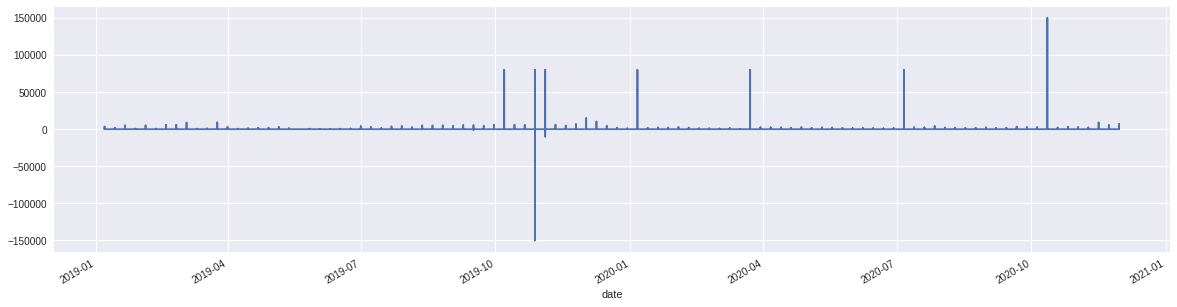

In [71]:
df2b['units'].plot(figsize=(20,5));

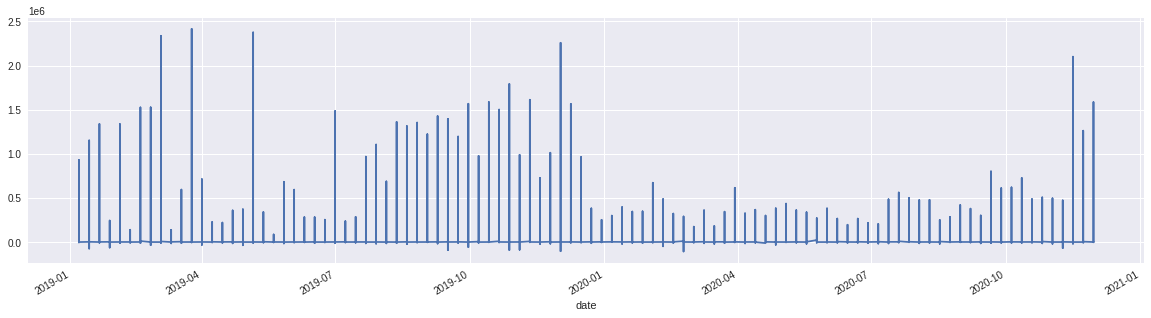

In [72]:
df2b['monetary'].plot(figsize=(20,5));

In [73]:
# For greater visibility in the plots we convert the dates to monthly periods and we aggregate the units and revenue of the same period

df2c = df2b.to_period("M")

In [74]:
df2c.head()

,country,id,monetary,units
date,,,,
2019-01,KR,702234,808.08,1
2019-02,KR,702234,1606.80,2
2019-02,KR,3618438,803.40,1
2019-03,KR,3618438,803.40,1
2019-03,KR,3618438,803.40,1


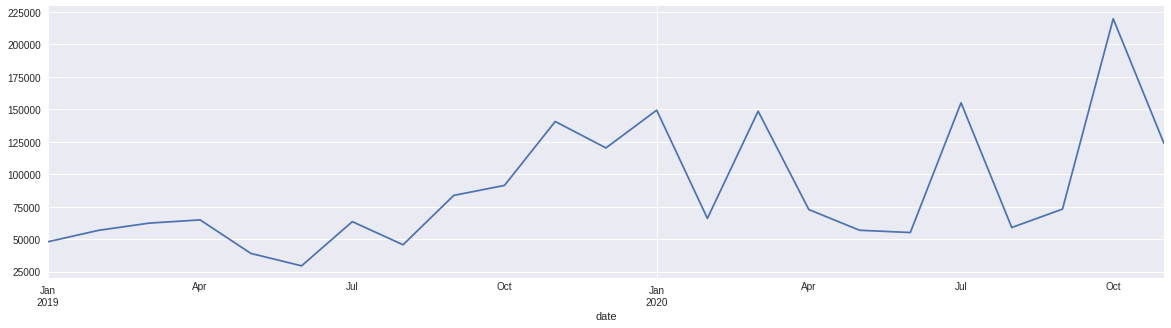

In [75]:
df2c['units'].groupby('date').agg(sum).plot(figsize=(20,5));

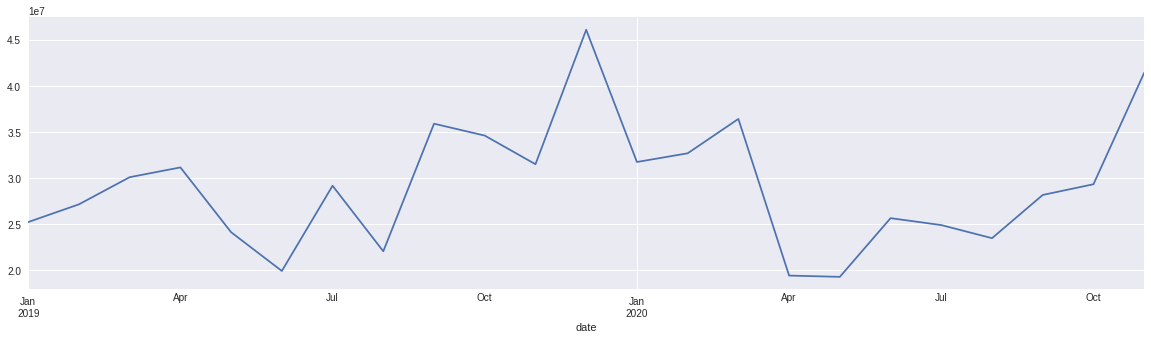

In [86]:
df2c['monetary'].groupby('date').agg(sum).plot(figsize=(20,5));

### Transform data to obtain RFM

In [87]:
print('Sales from {} to {}'.format(df2['date'].min(),
                                    df2['date'].max()))

Sales from 2019-01-07 00:00:00 to 2020-11-30 00:00:00


In [89]:
#Let's focus on sales from last 365 days since most recent date

period = 365
date_N_days_ago = df2['date'].max() - timedelta(days=period)

In [90]:
# We remove the rows with dates older than 365 days ago

df2 = df2[df2['date']> date_N_days_ago]

In [91]:
df2.reset_index(drop=True, inplace=True)

In [92]:
df2.head()

,country,id,monetary,units,date
0,KR,4375152,773.58,1,2019-12-16
1,KR,705462,337.26,1,2019-12-09
2,KR,705462,337.26,1,2019-12-23
3,KR,705462,421.56,2,2019-12-16
4,KR,706854,391.50,1,2019-12-09


In [93]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124640 entries, 0 to 124639
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   country   124640 non-null  object        
 1   id        124640 non-null  int64         
 2   monetary  124640 non-null  float64       
 3   units     124640 non-null  int64         
 4   date      124640 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.8+ MB


In [94]:
# There are customers with the same 'id' in several countries. This causes errors in the monetary values
# Let's create a unique 'id+' identifier that combines country code and customer id

df3 = df2.copy()

df3['id+'] = df3['country'].map(str) + df3['id'].map(str)

In [95]:
df3.head()

,country,id,monetary,units,date,id+
0,KR,4375152,773.58,1,2019-12-16,KR4375152
1,KR,705462,337.26,1,2019-12-09,KR705462
2,KR,705462,337.26,1,2019-12-23,KR705462
3,KR,705462,421.56,2,2019-12-16,KR705462
4,KR,706854,391.50,1,2019-12-09,KR706854


In [96]:
# We set the NOW date one day after the last sale

NOW = df3['date'].max() + timedelta(days=1)
NOW

Timestamp('2020-12-01 00:00:00')

In [97]:
# We add a column, 'days_since_last_purchase', with the days between purchase date and the latest date

df3['days_since_purchase'] = df3['date'].apply(lambda x:(NOW - x).days)

In [98]:
df3.head()

,country,id,monetary,units,date,id+,days_since_purchase
0,KR,4375152,773.58,1,2019-12-16,KR4375152,351
1,KR,705462,337.26,1,2019-12-09,KR705462,358
2,KR,705462,337.26,1,2019-12-23,KR705462,344
3,KR,705462,421.56,2,2019-12-16,KR705462,351
4,KR,706854,391.50,1,2019-12-09,KR706854,358


In [140]:
df3[df3['id+']=='KR706854']

,country,id,monetary,units,date,id+,days_since_purchase
4,KR,706854,391.50,1,2019-12-09,KR706854,358
5,KR,706854,388.68,1,2019-12-30,KR706854,337
14169,KR,706854,369.66,1,2020-04-06,KR706854,239
14192,KR,706854,374.76,1,2020-07-27,KR706854,127
14210,KR,706854,371.82,1,2020-11-09,KR706854,22


In [160]:
# Recency will be the minimum of 'days_since_last_purchase' for each customer
# Frequency will be the total number of orders in the period for each customer

aggr = {
    'days_since_purchase': lambda x:x.min(),
    'date': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)])
}

In [161]:
aggr

{'date': <function __main__.<lambda>>,
 'days_since_purchase': <function __main__.<lambda>>}

In [164]:
rfm = df3.groupby(['id', 'id+', 'country']).agg(aggr).reset_index()
rfm.rename(columns={'days_since_purchase': 'recency',
                   'date': 'frequency'},
          inplace=True)

In [165]:
rfm

,id,id+,country,recency,frequency
0,600018,CN600018,CN,29,7
1,600060,CN600060,CN,155,1
2,600462,CN600462,CN,211,2
3,600888,CN600888,CN,8,3
4,601014,CN601014,CN,225,1
...,...,...,...,...,...
16564,241575552,IQ241575552,IQ,15,1
16565,241794972,IQ241794972,IQ,351,1
16566,241888554,IQ241888554,IQ,43,1
16567,241900254,IQ241900254,IQ,8,62


In [ ]:
# We check customers with id 3790218 have different recency and frequency values per country

rfm[rfm['id']==3790218]

,id,id+,country,recency,frequency
11057,3790218,AF3790218,AF,309,1
11058,3790218,BD3790218,BD,176,4
11059,3790218,CN3790218,CN,1,60
11060,3790218,ID3790218,ID,260,9
11061,3790218,IQ3790218,IQ,176,1
11062,3790218,MM3790218,MM,183,3
11063,3790218,PH3790218,PH,127,3
11064,3790218,PK3790218,PK,43,5
11065,3790218,TH3790218,TH,295,1
11066,3790218,TR3790218,TR,29,10


In [ ]:
# We get the revenue of the last 365 days per customer

df3[df3['date'] >= NOW - timedelta(days=period)]\
    .groupby('id+')['monetary'].sum()

id+
AF186035892       277.86
AF1915092      250651.86
AF1915920        2238.60
AF1916280         612.78
AF1917144       29793.18
                 ...    
VN991620         1093.86
VN993528         1018.86
VN993996         4037.28
VN995010          544.32
VN998130          384.84
Name: monetary, Length: 16569, dtype: float64

In [ ]:
# Example: getting only the monetary value for specific customer with id 3790218

df3[ (df3['id'] == 3790218) & (df3['date'] >= NOW - timedelta(days=period))]\
    .groupby('id+')['monetary'].sum()

id+
AF3790218      9706.08
BD3790218      7267.38
CN3790218    716199.60
ID3790218     49154.22
IQ3790218      1243.08
MM3790218      7110.60
PH3790218      1013.58
PK3790218    211108.20
TH3790218      1245.48
TR3790218     16072.02
VN3790218      3377.34
Name: monetary, dtype: float64

In [ ]:
# We add the revenue from df3 of last period per customer to rfm dataframe

rfm['monetary'] = rfm['id+']\
    .apply(lambda x: df3[ (df3['id+'] == x) & (df3['date'] >= NOW - timedelta(days=period))]\
    .groupby(['id', 'country']).sum().iloc[0,0])

In [ ]:
rfm.head()

,id,id+,country,recency,frequency,monetary
0,600018,CN600018,CN,29,7,21402.78
1,600060,CN600060,CN,155,1,1201.14
2,600462,CN600462,CN,211,2,2033.64
3,600888,CN600888,CN,8,3,2335.80
4,601014,CN601014,CN,225,1,230.52


In [ ]:
# Checking monetary value is correct by checking on our biggest customer

rfm[rfm['monetary']==rfm['monetary'].max()]

,id,id+,country,recency,frequency,monetary
173,638544,CN638544,CN,1,217,21482332.56


In [ ]:
rfm[rfm['frequency']==rfm['frequency'].max()]

,id,id+,country,recency,frequency,monetary
8290,3249114,TR3249114,TR,1,1351,2731448.04


In [ ]:
# We check that customers with id 3790218 get a different monetary value per country

rfm[rfm['id']==3790218]

,id,id+,country,recency,frequency,monetary
11057,3790218,AF3790218,AF,309,1,9706.08
11058,3790218,BD3790218,BD,176,4,7267.38
11059,3790218,CN3790218,CN,1,60,716199.60
11060,3790218,ID3790218,ID,260,9,49154.22
11061,3790218,IQ3790218,IQ,176,1,1243.08
11062,3790218,MM3790218,MM,183,3,7110.60
11063,3790218,PH3790218,PH,127,3,1013.58
11064,3790218,PK3790218,PK,43,5,211108.20
11065,3790218,TH3790218,TH,295,1,1245.48
11066,3790218,TR3790218,TR,29,10,16072.02


In [ ]:
# Let's frop the column 'id+'

rfm.drop(['id+'], axis=1, inplace=True)

### Calculate the R, F and M scores

In [ ]:
# We assign a rate between 1 and 5 depending on recency, monetary and frequency parameters
# We use the quintiles method, dividing every feature on groups that contain 20 % of the samples

quintiles = rfm[['recency', 'frequency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 4.0, 0.8: 9.0},
 'monetary': {0.2: 967.5,
  0.4: 2212.2,
  0.6: 4852.548000000001,
  0.8: 13957.500000000005},
 'recency': {0.2: 15.0, 0.4: 50.0, 0.6: 120.0, 0.8: 239.0}}

In [ ]:
# Assigning scores from 1 to 5
# Higher values are better for frequency and monetary, while lower values are better for recency

def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1

In [ ]:
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5

In [ ]:
# We asssign R, F and M scores to each customer

rfm['r'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['f'] = rfm['frequency'].apply(lambda x: fm_score(x, 'frequency'))
rfm['m'] = rfm['monetary'].apply(lambda x: fm_score(x, 'monetary'))

In [ ]:
rfm.head()

,id,country,recency,frequency,monetary,r,f,m
0,600018,CN,29,7,21402.78,4,4,5
1,600060,CN,155,1,1201.14,2,1,2
2,600462,CN,211,2,2033.64,2,2,2
3,600888,CN,8,3,2335.80,5,3,3
4,601014,CN,225,1,230.52,2,1,1


In [ ]:
# Combine R, F and M scores to create a unique RFM score

rfm['rfm_score'] = rfm['r'].map(str) + rfm['f'].map(str) + rfm['m'].map(str)
rfm.head()

,id,country,recency,frequency,monetary,r,f,m,rfm_score
0,600018,CN,29,7,21402.78,4,4,5,445
1,600060,CN,155,1,1201.14,2,1,2,212
2,600462,CN,211,2,2033.64,2,2,2,222
3,600888,CN,8,3,2335.80,5,3,3,533
4,601014,CN,225,1,230.52,2,1,1,211


In [ ]:
# With this rfm scores we would have 125 segments of customers
# To make a more simple segment map of 11 segments, we combine f and m scores, rounding them down
# fm = (f+m)/2

In [ ]:
def truncate(x):
    return math.trunc(x)

In [ ]:
rfm['fm'] = ((rfm['f'] + rfm['m'])/2).apply(lambda x: truncate(x))

In [ ]:
rfm.head()

,id,country,recency,frequency,monetary,r,f,m,rfm_score,fm
0,600018,CN,29,7,21402.78,4,4,5,445,4
1,600060,CN,155,1,1201.14,2,1,2,212,1
2,600462,CN,211,2,2033.64,2,2,2,222,2
3,600888,CN,8,3,2335.80,5,3,3,533,3
4,601014,CN,225,1,230.52,2,1,1,211,1


### Segment	Description
* **Champions**	Bought recently, buy often and spend the most
* **Loyal Customers**	Buy on a regular basis. Responsive to promotions.
* **Potential Loyalists**	Recent customers with average frequency.
* **Recent Customers**	Bought most recently, but not often.
* **Promising**	Recent shoppers, but haven’t spent much.
* **Customers Needing Attention**	Above average recency, frequency and monetary values. May not have bought very recently though.
* **About To Sleep**	Below average recency and frequency. Will lose them if not reactivated.
* **At Risk**	Purchased often but a long time ago. Need to bring them back!
* **Can’t Lose Them**	Used to purchase frequently but haven’t returned for a long time.
* **Hibernating**	Last purchase was long back and low number of orders.
* **Lost** Purchased long time ago and never came back.

In [ ]:
# We create a segment map of only 11 segments based on only two scores: 'r' and 'fm'

segment_map = {
    r'22': 'hibernating',
    r'[1-2][1-2]': 'lost',
    r'15': 'can\'t lose',
    r'[1-2][3-5]': 'at risk',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'55': 'champions',
    r'[3-5][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists'
}

rfm['segment'] = rfm['r'].map(str) + rfm['fm'].map(str)
rfm['segment'] = rfm['segment'].replace(segment_map, regex=True)
rfm.head()

,id,country,recency,frequency,monetary,r,f,m,rfm_score,fm,segment
0,600018,CN,29,7,21402.78,4,4,5,445,4,loyal customers
1,600060,CN,155,1,1201.14,2,1,2,212,1,lost
2,600462,CN,211,2,2033.64,2,2,2,222,2,hibernating
3,600888,CN,8,3,2335.80,5,3,3,533,3,potential loyalists
4,601014,CN,225,1,230.52,2,1,1,211,1,lost


In [ ]:
rfm.isnull().sum()

id           0
country      0
recency      0
frequency    0
monetary     0
r            0
f            0
m            0
rfm_score    0
fm           0
segment      0
dtype: int64

### Visualize our customers segments

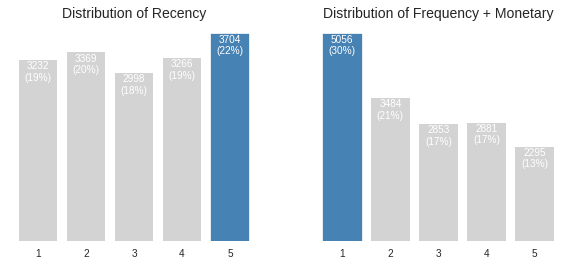

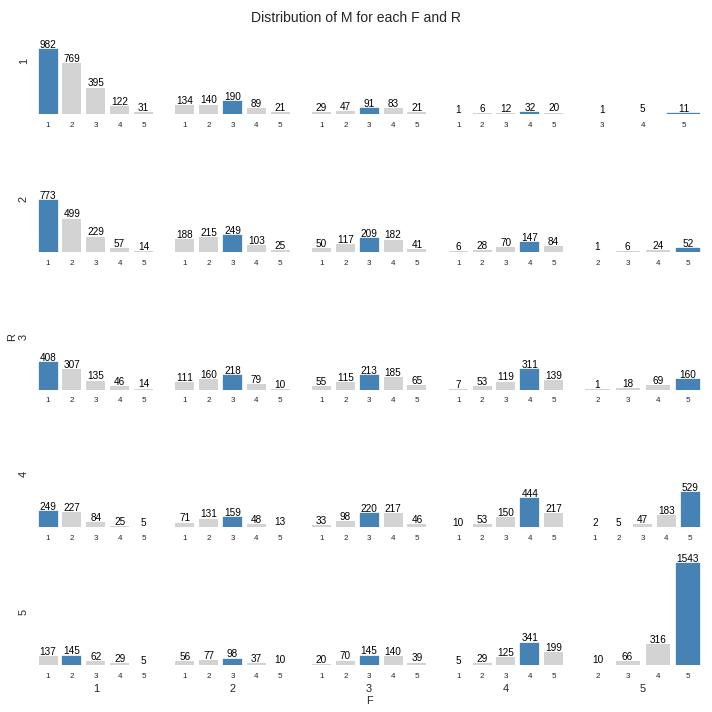

In [ ]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['r', 'fm']):
    parameters = {'r':'Recency', 'fm':'Frequency + Monetary'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='lightgrey')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('steelblue')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')
        
plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['r'] == r) & (rfm['f'] == f)]['m'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='lightgrey')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('steelblue')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# We see that recency is evenly distributed

# 30 % of customers don't purchase very often high volumes (frequency + monetary 1)

# Customers who spend the most are the more frequent (5) and recent (5)

# Second tier customers who spend the most are low frequency (1) and low recency (1-2)

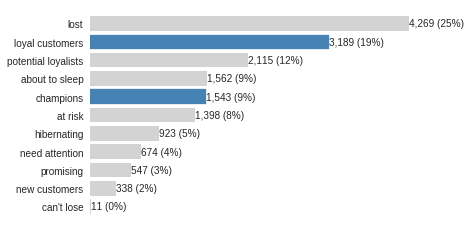

In [ ]:
# Count the number of customers in each segment

segments_counts = rfm['segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='lightgrey')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('steelblue')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [ ]:
# We have a lot of customers who don't buy frequently from us (30 % are lost or hibernating) 
# However, 28 % of our customers are either champions or loyal customers

In [ ]:
rfm['segment'].unique()

array(['loyal customers', 'lost', 'hibernating', 'potential loyalists',
       'new customers', 'need attention', 'at risk', 'champions',
       'about to sleep', 'promising', "can't lose"], dtype=object)

In [ ]:
# We take a look on some segments

rfm[rfm['segment']=="can't lose"].sort_values(by='monetary', ascending=False)

,id,country,recency,frequency,monetary,r,f,m,rfm_score,fm,segment
13028,4096386,JP,260,105,220267.86,1,5,5,155,5,can't lose
3502,2443284,IN,246,10,102208.02,1,5,5,155,5,can't lose
14174,4262646,IN,316,10,91909.44,1,5,5,155,5,can't lose
2435,1803672,IN,267,12,70506.96,1,5,5,155,5,can't lose
13254,4132968,VN,253,26,42535.14,1,5,5,155,5,can't lose
11222,3815274,IN,267,11,37968.72,1,5,5,155,5,can't lose
1458,1031454,PH,267,23,31833.30,1,5,5,155,5,can't lose
5437,2809158,IN,274,12,27150.12,1,5,5,155,5,can't lose
14644,4326906,IN,337,11,22351.68,1,5,5,155,5,can't lose
259,668070,MM,267,11,21886.92,1,5,5,155,5,can't lose


In [ ]:
rfm[rfm['segment']=="need attention"].sort_values(by='monetary', ascending=False).head(10)

,id,country,recency,frequency,monetary,r,f,m,rfm_score,fm,segment
8245,3242664,TR,64,1,73823.58,3,1,5,315,3,need attention
13065,4107798,JP,120,2,67257.48,3,2,5,325,3,need attention
9847,3561900,ID,120,1,59700.00,3,1,5,315,3,need attention
6626,2921070,ID,71,2,34730.22,3,2,5,325,3,need attention
10009,3587772,CN,92,1,29961.00,3,1,5,315,3,need attention
3087,2131194,JP,57,1,28543.74,3,1,5,315,3,need attention
13463,4160490,JP,99,1,24842.22,3,1,5,315,3,need attention
1251,993414,KR,71,2,22018.32,3,2,5,325,3,need attention
3936,2544588,BD,71,2,19043.82,3,2,5,325,3,need attention
3616,2468010,TH,85,2,18599.58,3,2,5,325,3,need attention


In [ ]:
rfm[rfm['segment']=='loyal customers'].sort_values(by='monetary', ascending=False).head(10)

,id,country,recency,frequency,monetary,r,f,m,rfm_score,fm,segment
15420,4422780,TR,92,13,2315341.14,3,5,5,355,5,loyal customers
2882,2030526,JP,22,50,1519339.86,4,5,5,455,5,loyal customers
3220,2182446,JP,29,18,1492057.68,4,5,5,455,5,loyal customers
12660,4041366,PK,50,9,736626.96,4,4,5,445,4,loyal customers
5612,2853774,VN,8,6,712230.00,5,4,5,545,4,loyal customers
10343,3649728,PH,29,81,579167.52,4,5,5,455,5,loyal customers
8284,3248568,TR,64,3,573792.72,3,3,5,335,4,loyal customers
15450,4427148,IN,29,14,502843.32,4,5,5,455,5,loyal customers
14678,4332210,ID,43,21,474773.40,4,5,5,455,5,loyal customers
2802,1985592,IQ,78,4,460390.86,3,3,5,335,4,loyal customers


In [ ]:
rfm[rfm['segment']=='champions'].sort_values(by='monetary', ascending=False).head(10)

,id,country,recency,frequency,monetary,r,f,m,rfm_score,fm,segment
173,638544,CN,1,217,21482332.56,5,5,5,555,5,champions
15436,4424580,CN,1,104,16912322.46,5,5,5,555,5,champions
14754,4341960,TR,1,200,16550997.90,5,5,5,555,5,champions
11942,3929094,ID,1,470,8748884.64,5,5,5,555,5,champions
9626,3520734,JP,1,198,6207519.96,5,5,5,555,5,champions
15915,4494150,TR,1,57,4874668.14,5,5,5,555,5,champions
10168,3618438,KR,8,1020,4615660.08,5,5,5,555,5,champions
14027,4245048,PH,1,993,4358515.98,5,5,5,555,5,champions
3050,2111100,IN,1,876,4270717.80,5,5,5,555,5,champions
11742,3894492,PH,8,63,4106366.22,5,5,5,555,5,champions


In [ ]:
rfm['monetary'].mean()

21629.6111497373

In [ ]:
# Customers with monetary over the average that need attention

rfm[(rfm['monetary']>rfm['monetary'].mean()) & (rfm['segment']=='need attention')]\
    .sort_values(by='monetary', ascending=False)

,id,country,recency,frequency,monetary,r,f,m,rfm_score,fm,segment
8245,3242664,TR,64,1,73823.58,3,1,5,315,3,need attention
13065,4107798,JP,120,2,67257.48,3,2,5,325,3,need attention
9847,3561900,ID,120,1,59700.00,3,1,5,315,3,need attention
6626,2921070,ID,71,2,34730.22,3,2,5,325,3,need attention
10009,3587772,CN,92,1,29961.00,3,1,5,315,3,need attention
3087,2131194,JP,57,1,28543.74,3,1,5,315,3,need attention
13463,4160490,JP,99,1,24842.22,3,1,5,315,3,need attention
1251,993414,KR,71,2,22018.32,3,2,5,325,3,need attention


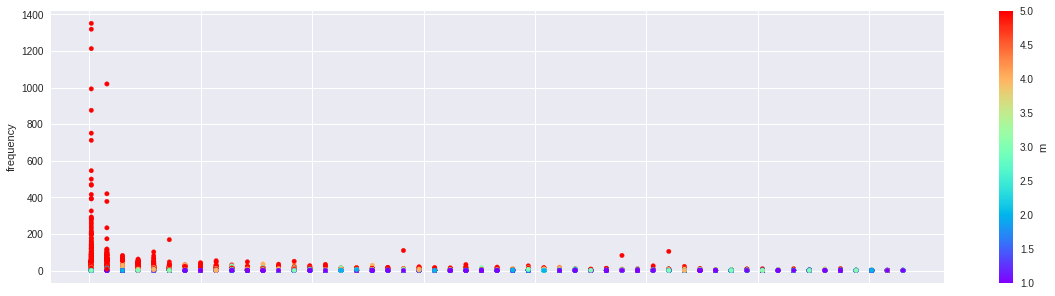

In [ ]:
# Let's do a scatter plot to explore the distribution of customers
# Using a colormap for the m score, we see that the majority of customers who spend the most also purchase more frequently

plt.rcParams["figure.figsize"] = (20, 5)
rfm.plot.scatter(x='recency', y='frequency', c='m', cmap='rainbow');

In [ ]:
# Using a colormap for the m score, we see the majority of customers who spend the most also purchase more frequently